# Section 1 — Report Header & Hypothesis

**Report Title:** _Do Media Posts Get More Likes on Bluesky?_  
**Your Name:** _Chris Cowles_  
**Date:** _October 12, 2025_

### Hypothesis
Posts that include media (images or external embeds) receive more likes on average than plain-text posts.

### Theoretical Rationale
Media is attention grabbing and often easier to process quickly. If users notice media faster than text, those posts may collect more likes. This is a simple way to test how content type relates to engagement.

### What I’ll Do 
- Pull recent posts from a small set of public accounts.
- Label each post as **media** or **text** based on the presence of an embed.
- Compare average likes (and medians) between the two groups.


# Section 2 — Endpoint Plan (Design Your Data Collection)

 https://docs.bsky.app/docs/category/http-reference

- `GET /xrpc/app.bsky.feed.getAuthorFeed` → returns recent posts for a given handle. Includes like/reply/repost counts and the embed (for media). Good for labeling media vs text.
- `GET /xrpc/app.bsky.actor.getProfile` → basic profile info per handle (followers, posts). Useful context and shows that we can merge account-level data with post-level data.


### Reliability
- The data may not be reliable because of how small the sample size is. I am only analyzing 3 Bluesky users for this study.


# Section 3 Data Collection
Collect posts that match a query. Adjust `QUERY`, `MAX_POSTS`, and any filters your hypothesis requires.


Imports & setup

In [32]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import urllib.parse as ul
import time

APPVIEW = "https://public.api.bsky.app"
pd.set_option("display.max_columns", 100)

Helper functions for the chosen endpoints

In [33]:
def get_profile(handle: str) -> dict:
    url = f"{APPVIEW}/xrpc/app.bsky.actor.getProfile?actor={ul.quote(handle)}"
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    return r.json()

def get_author_feed(handle: str, limit: int = 50, cursor: str | None = None) -> dict:
    params = {"actor": handle, "limit": limit}
    if cursor:
        params["cursor"] = cursor
    url = f"{APPVIEW}/xrpc/app.bsky.feed.getAuthorFeed"
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    return r.json()

Array of handles + cap # of posts per user via pagination

In [34]:
handles = [
    "jack.bsky.social",
    "bsky.app",
    "jay.bsky.social",
]
MAX_PER_USER = 100  

Collect posts

In [35]:
all_posts = []
for h in handles:
    cursor = None
    fetched = 0
    while fetched < MAX_PER_USER:
        data = get_author_feed(h, limit=100, cursor=cursor)
        feed = data.get("feed", [])
        if not feed:
            break
        for item in feed:
            post = item.get("post", {}) or {}
            record = post.get("record", {}) or {}
            # An embed indicates media (images, external links, etc.) in AppView
            has_media = "embed" in post and post.get("embed") is not None
            all_posts.append({
                "author_handle": post.get("author", {}).get("handle"),
                "post_uri": post.get("uri"),
                "created_at": record.get("createdAt"),
                "text": record.get("text", ""),
                "like_count": post.get("likeCount"),
                "reply_count": post.get("replyCount"),
                "repost_count": post.get("repostCount"),
                "has_media": has_media,
            })
        fetched += len(feed)
        cursor = data.get("cursor")
        if not cursor:
            break
        time.sleep(0.2)  # polite delay

posts_df = pd.DataFrame(all_posts)
if not posts_df.empty:
    posts_df["created_at"] = pd.to_datetime(posts_df["created_at"], errors="coerce", utc=True)
posts_df.head()

,author_handle,post_uri,created_at,text,like_count,reply_count,repost_count,has_media
0,jack.bsky.social,at://did:plc:cyo4fmu7ktbgaobgasfoja4g/app.bsky...,2025-05-13 20:56:01.981000+00:00,open source everything,6,5,2,False
1,matthewwilding.bsky.social,at://did:plc:ccpzzqcvmpaieyrcdszm73t4/app.bsky...,2025-10-10 15:44:12.646000+00:00,Fun fact: Bluesky is outperforming Twitter on ...,3796,78,248,False
2,timkellogg.me,at://did:plc:ckaz32jwl6t2cno6fmuw2nhn/app.bsky...,2025-10-10 16:04:57.235000+00:00,i think what defines bluesky is your ability t...,1101,46,57,False
3,boostblue.bsky.social,at://did:plc:e5sycehmo2p3ze6qvrrsurcc/app.bsky...,2025-10-07 18:50:30.314000+00:00,Boost Blue's iPad update is live!!!\n\nDownloa...,452,17,39,True
4,themerl.bsky.social,at://did:plc:denuvqodvvnzxtuitumle4vs/app.bsky...,2025-10-09 16:40:50.348000+00:00,it makes us extremely proud to know that among...,1304,18,59,True


## Data Collection (Endpoint 1): 
`app.bsky.feed.searchPosts`
Flatten key fields from Bluesky PostView objects.

## Data Collection (Endpoint 2): 

`app.bsky.actor.getProfiles`
- Enrich the post data with profile attributes (followers count, display name, etc.).  
- We gather unique author identifiers (`did`) from the posts and request them in batches.
- NOTE: Will this be a for loop?


# Section 4 — Build DataFrames

Use a pandas method to combine your DataFrames. Use your own endpoints and dataframes. Adjust based on your plan:
- **merge** on a key (`author_did`), or
- **concat** to stack rows from multiple endpoints, or
- **join** to add columns using an index.
- **Wrangling** (select, clean, sort)

  


Basic summary: compare likes for media vs text

In [29]:
if posts_df.empty:
    print("No posts collected. Try different handles or run again later.")
else:
    grp = (posts_df.groupby("has_media", as_index=False)
           .agg(avg_likes=("like_count", "mean"),
                median_likes=("like_count", "median"),
                posts_sampled=("post_uri", "count")))
    grp["post_type"] = grp["has_media"].map({True: "Media", False: "Text"})
    grp[["post_type","avg_likes","median_likes","posts_sampled"]]

Simple bar chart: Avg likes by post type (Media vs Text)

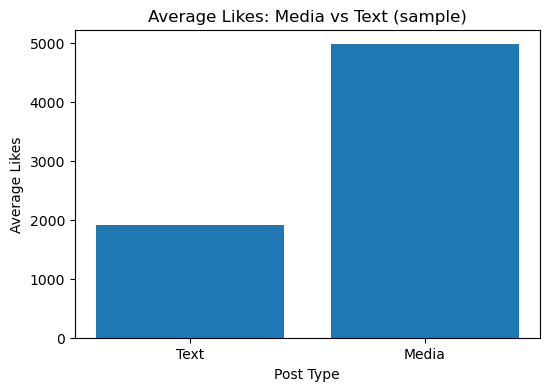

In [30]:
if 'grp' in locals() and not grp.empty:
    plt.figure(figsize=(6,4))
    plt.bar(grp["post_type"], grp["avg_likes"])
    plt.title("Average Likes: Media vs Text (sample)")
    plt.xlabel("Post Type")
    plt.ylabel("Average Likes")
    plt.show()
else:
    print("Nothing to plot.")

Merge with profiles to demonstrate DataFrame combination

In [31]:
profiles = []
for h in sorted(set(posts_df["author_handle"])):
    try:
        p = get_profile(h)
        profiles.append({
            "author_handle": p.get("handle"),
            "followers": p.get("followersCount"),
            "posts_total": p.get("postsCount"),
        })
    except Exception as e:
        print("profile error for", h, e)

profiles_df = pd.DataFrame(profiles)
if not profiles_df.empty:
    author_like_means = (posts_df.groupby("author_handle", as_index=False)
                         .agg(avg_likes=("like_count", "mean"), count_posts=("post_uri","count")))
    merged = pd.merge(author_like_means, profiles_df, on="author_handle", how="left")
    merged.sort_values("followers", ascending=False).head(10)

# Section 5 — Conclusion

**What I see:**  
If the Media bar is higher than Text, it supports the hypothesis that media posts get more likes on average. If the difference is small, we may need a larger sample or to compare within each author to control for audience size.

**Notes & limits:**  
We only pulled recent posts; results can change over time.  A few viral posts can skew the mean. Medians help reduce that effect.  Handles are a small convenience sample. Expanding the list would make the result more reliable.

**Next steps:**  
Increase the number of accounts. Add time-of-day/day-of-week controls. Break media into images vs external links vs video (if available) to see differences within media types.
